**Домашнее задание №3 (Математические основы машинного обучения)**

## Часть 1. Синтетические данные

## Библиотеки

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
import sklearn.metrics 

## Общие функции

Функции моделей

In [ ]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [ ]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty  + l2_term)

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))     
    #---------------------------------
    def forward(self, X):     
        return self.sigmoid(np.dot(X, self.weights))   
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1   
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return self.to_class(yhat)

    #---------------------------------
    def predict_prob(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat 
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        plt.figure(figsize = figsize)
        cm_bright = ListedColormap(colors)
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);
        h =  (X[:, 0].max() - X[:, 0].min())/50
        x_min, x_max = X[:, 0].min()-0.5 , X[:, 0].max()+0.5
        y_min, y_max = X[:, 1].min()-0.5 , X[:, 1].max()+0.5    
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly:
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
        else:
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
        cm = plt.cm.RdBu
        Z = Z.reshape(xx.shape) 
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

In [ ]:
def to_polynom(X, order = 2):
    order_range = range(2, order+1,1)
    out = np.copy(X) 
    for i in order_range:
        out = np.hstack([out, np.power(X,i)])
    return out

## Визуализация

In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

# Синтетические данные

In [ ]:
#общие функции для синтетических данных:
def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises, 
                          random_state=random_state)
    
    elif method == 'circles':    
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )

    
    return X,y

## Знак Инь-Янь

In [ ]:
#параметры для ДЗ:
N = 120
NOISES = 0.35
ORDER = 5
BATCH_SIZE = int(N * 0.1)

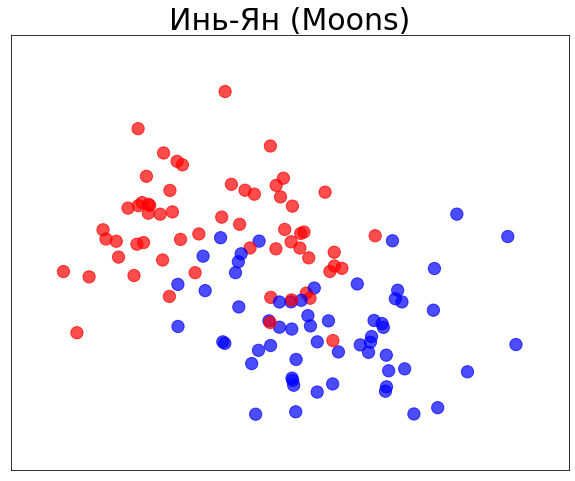

In [ ]:
X,y = make_binary_clf(N,method = 'moons', noises = NOISES)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y), 'Инь-Ян (Moons)')

In [ ]:
X_poly   = to_polynom(X, order = ORDER)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

### а) Проведем тестирование без регуляризации 

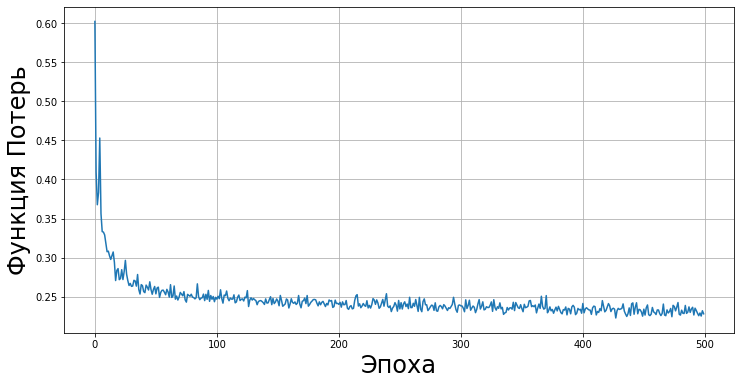

Train Accuracy: 0.8929; Test Accuracy: 0.9722
True Positives:0.9474	True Negatives:1.0000
False Positives:0.0526	False Negatives:0.0000
Accuracy:0.9722
Recall:1.0000	Precision:0.9474
f1 measure:0.9730


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size = BATCH_SIZE,)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

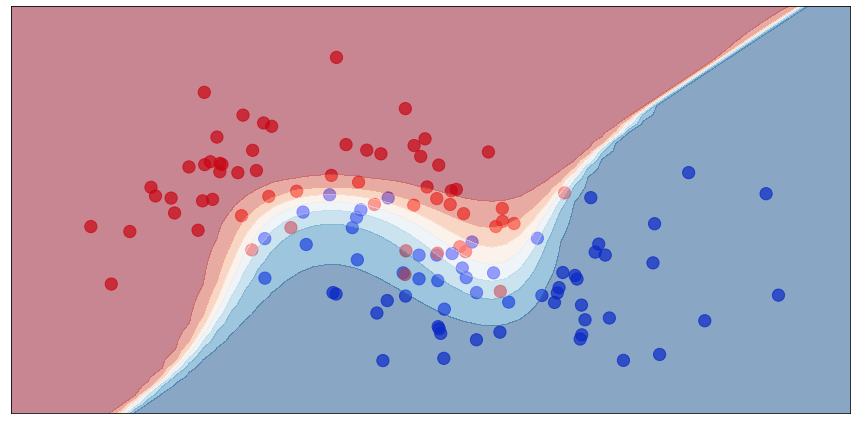

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

### б) Проведем тестирование c L2 

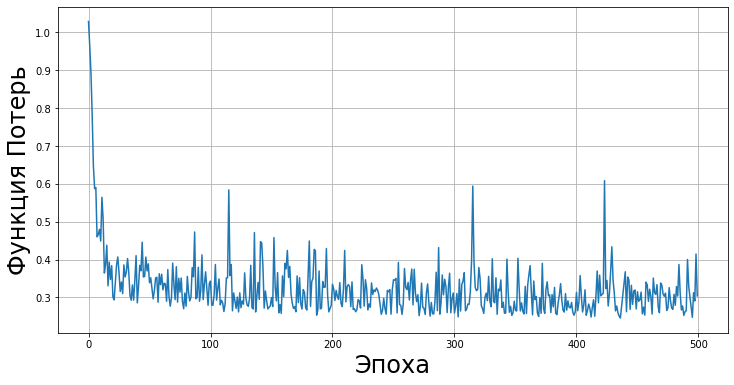

Train Accuracy: 0.8929; Test Accuracy: 0.9722
True Positives:0.9474	True Negatives:1.0000
False Positives:0.0526	False Negatives:0.0000
Accuracy:0.9722
Recall:1.0000	Precision:0.9474
f1 measure:0.9730


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=20, l2_penalty = 0.0001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

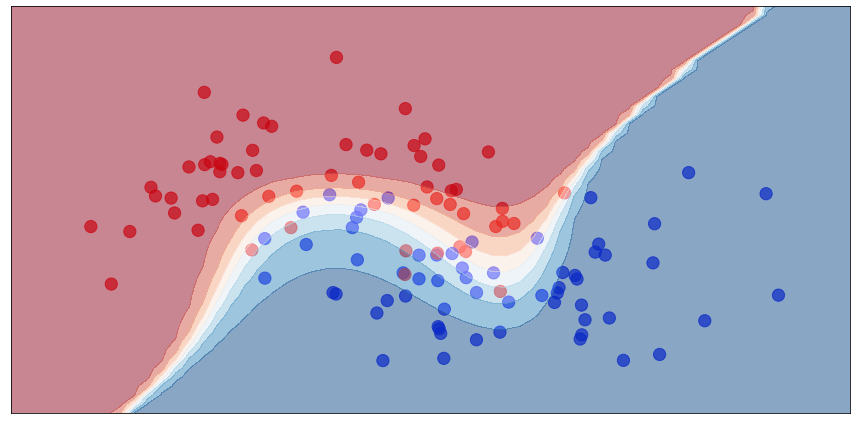

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

### в) Проведем тестирование c L1

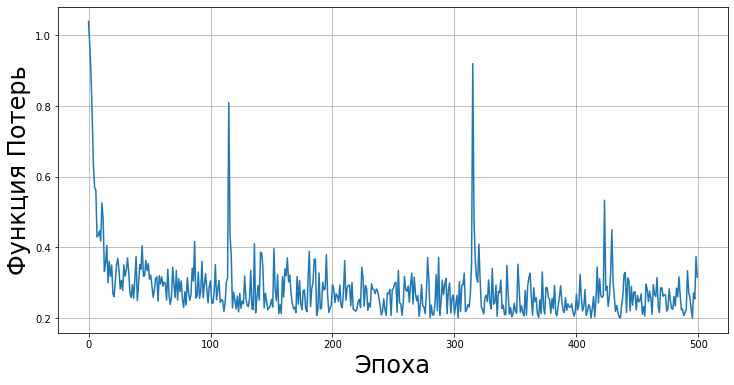

Train Accuracy: 0.8810; Test Accuracy: 0.9444
True Positives:0.9444	True Negatives:0.9444
False Positives:0.0556	False Negatives:0.0556
Accuracy:0.9444
Recall:0.9444	Precision:0.9444
f1 measure:0.9444


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=20, l1_penalty = 0.005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

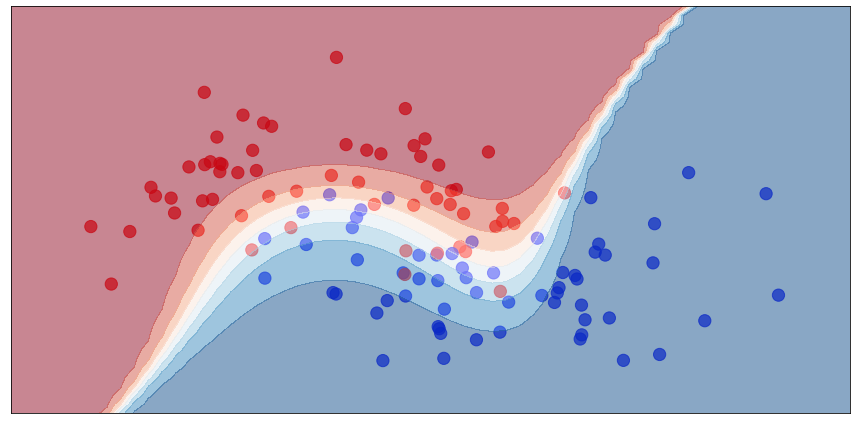

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

### г) Проведем тестирование с эластичной регуляризацией

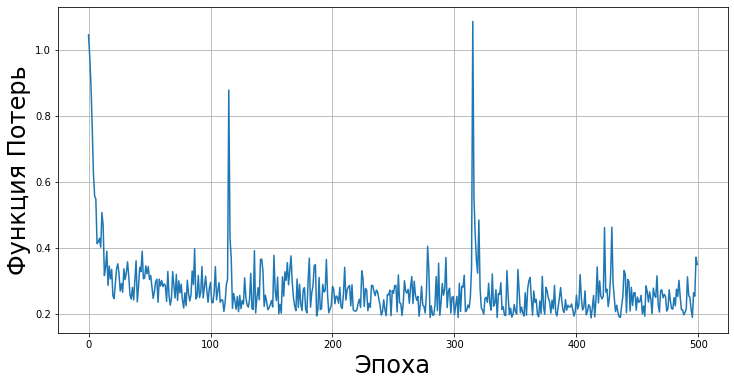

Train Accuracy: 0.8810; Test Accuracy: 0.9444
True Positives:0.9444	True Negatives:0.9444
False Positives:0.0556	False Negatives:0.0556
Accuracy:0.9444
Recall:0.9444	Precision:0.9444
f1 measure:0.9444


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=20, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

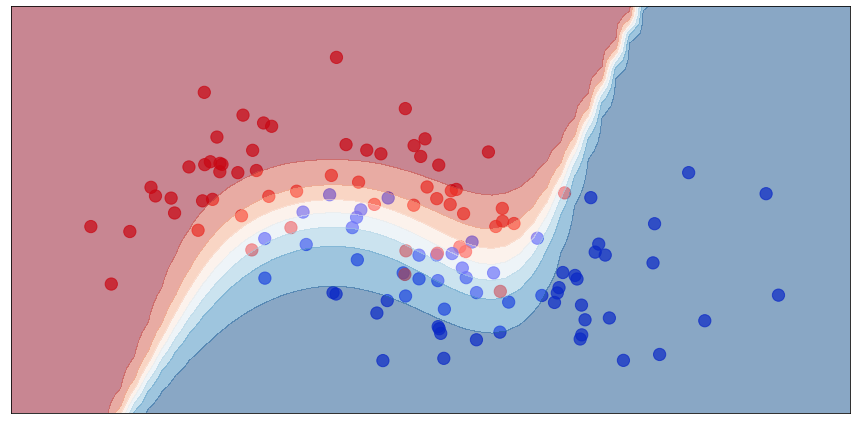

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

# Вывод:

При:

N = 120
NOISES = 0.35
ORDER = 5

Показатели:
Train Accuracy: 0.8929; Test Accuracy: 0.9722 True Positives:0.9474 True Negatives:1.0000 False Positives:0.0526 False Negatives:0.0000 Accuracy:0.9722 Recall:1.0000 Precision:0.9474 f1 measure:0.9730

Train Accuracy: 0.8929; Test Accuracy: 0.9722 True Positives:0.9474 True Negatives:1.0000 False Positives:0.0526 False Negatives:0.0000 Accuracy:0.9722 Recall:1.0000 Precision:0.9474 f1 measure:0.9730

Train Accuracy: 0.8810; Test Accuracy: 0.9444 True Positives:0.9444 True Negatives:0.9444 False Positives:0.0556 False Negatives:0.0556 Accuracy:0.9444 Recall:0.9444 Precision:0.9444 f1 measure:0.9444

Train Accuracy: 0.8810; Test Accuracy: 0.9444 True Positives:0.9444 True Negatives:0.9444 False Positives:0.0556 False Negatives:0.0556 Accuracy:0.9444 Recall:0.9444 Precision:0.9444 f1 measure:0.9444


Лучшие результаты показывают модели без регуляризации и с L2

## Концентрические круги

In [ ]:
#Параметры для ДЗ
N = 200
NOISES = 0.35
ORDER = 5
BATCH_SIZE = int(N * 0.1)

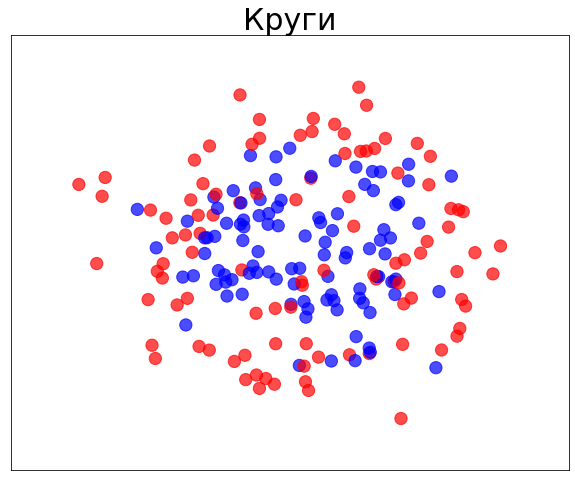

In [ ]:
X,y = make_binary_clf(N,method = 'circles', noises = NOISES)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Круги')

In [ ]:
X_poly   = to_polynom(X, order = ORDER)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

### а) Проведем тестирование без регуляризации 

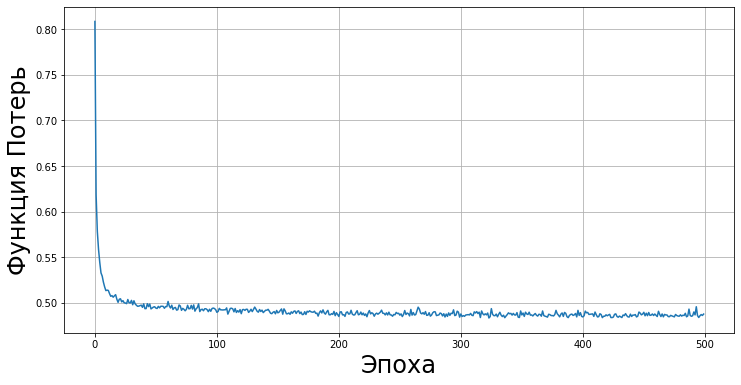

Train Accuracy: 0.7929; Test Accuracy: 0.6667
True Positives:0.6176	True Negatives:0.7308
False Positives:0.3824	False Negatives:0.2692
Accuracy:0.6667
Recall:0.7500	Precision:0.6176
f1 measure:0.6774


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size = BATCH_SIZE,)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

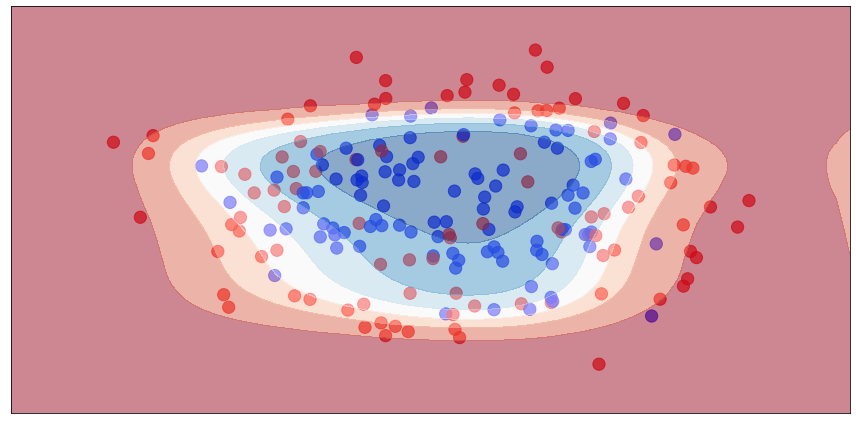

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

### б) Проведем тестирование c L2 

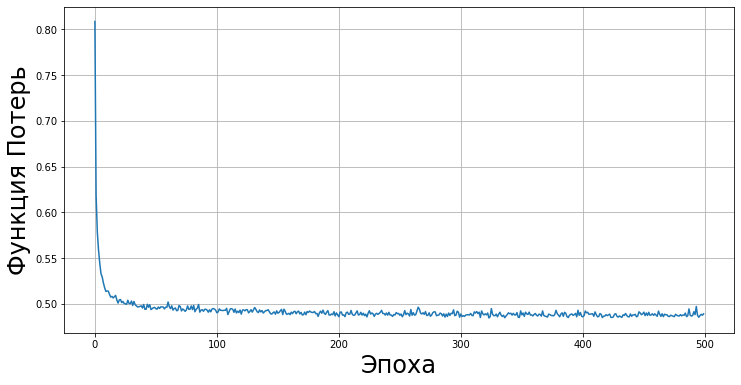

Train Accuracy: 0.7929; Test Accuracy: 0.6667
True Positives:0.6176	True Negatives:0.7308
False Positives:0.3824	False Negatives:0.2692
Accuracy:0.6667
Recall:0.7500	Precision:0.6176
f1 measure:0.6774


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=20, l2_penalty = 0.0001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

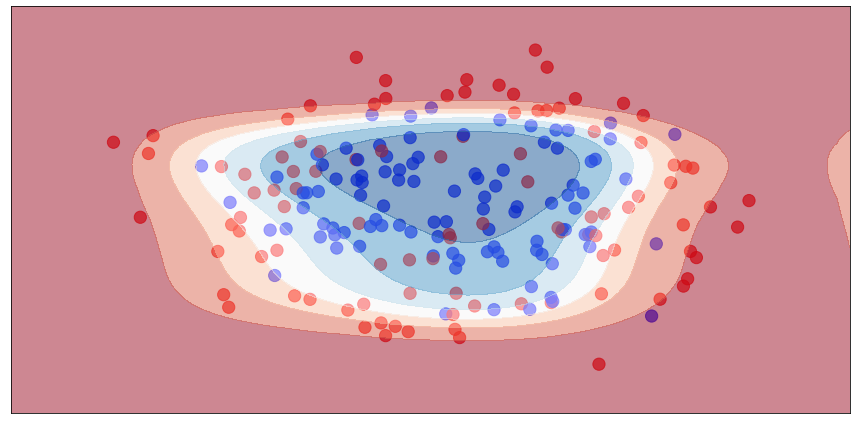

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

### в) Проведем тестирование c L1

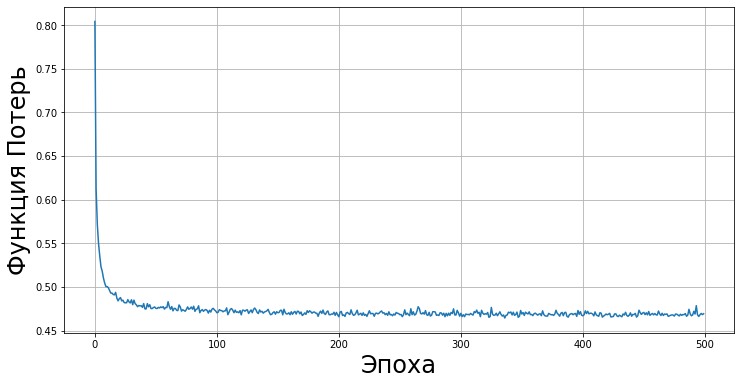

Train Accuracy: 0.7929; Test Accuracy: 0.7000
True Positives:0.6471	True Negatives:0.7692
False Positives:0.3529	False Negatives:0.2308
Accuracy:0.7000
Recall:0.7857	Precision:0.6471
f1 measure:0.7097


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=20, l1_penalty = 0.005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

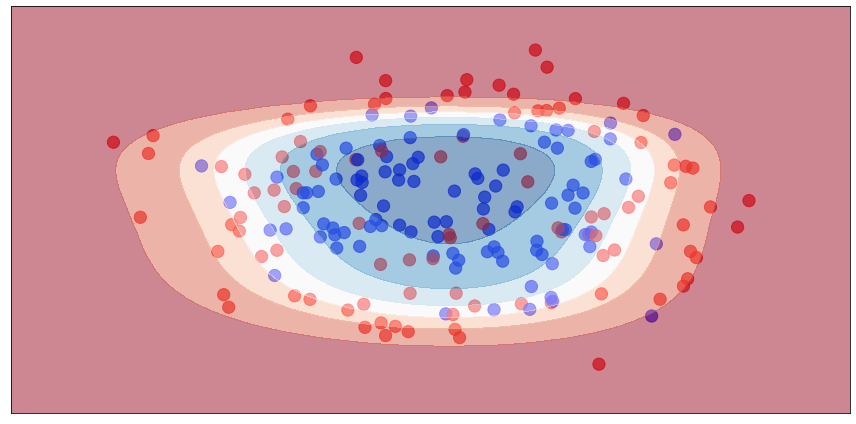

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

### г) Проведем тестирование с эластичной регуляризацией

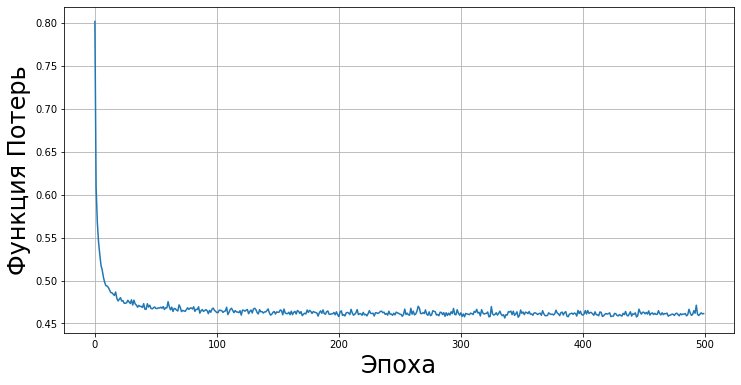

Train Accuracy: 0.7929; Test Accuracy: 0.7333
True Positives:0.6765	True Negatives:0.8077
False Positives:0.3235	False Negatives:0.1923
Accuracy:0.7333
Recall:0.8214	Precision:0.6765
f1 measure:0.7419


In [ ]:
regr = LogisticRegression(learning_rate=0.25, epochs=500, batch_size=20, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'Train Accuracy: %.4f; Test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

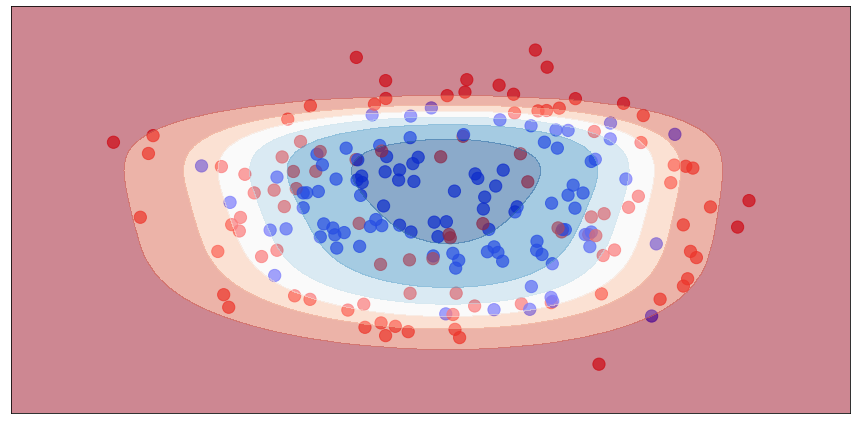

In [ ]:
regr.plot_desicion_function(X_poly, y, poly = True, order = ORDER)

# Вывод:

При:

N = 200
NOISES = 0.35
ORDER = 5

Train Accuracy: 0.7929; Test Accuracy: 0.6667 True Positives:0.6176 True Negatives:0.7308 False Positives:0.3824 False Negatives:0.2692 Accuracy:0.6667 Recall:0.7500 Precision:0.6176 f1 measure:0.6774

Train Accuracy: 0.7929; Test Accuracy: 0.6667 True Positives:0.6176 True Negatives:0.7308 False Positives:0.3824 False Negatives:0.2692 Accuracy:0.6667 Recall:0.7500 Precision:0.6176 f1 measure:0.6774

Train Accuracy: 0.7929; Test Accuracy: 0.7000 True Positives:0.6471 True Negatives:0.7692 False Positives:0.3529 False Negatives:0.2308 Accuracy:0.7000 Recall:0.7857 Precision:0.6471 f1 measure:0.7097

Train Accuracy: 0.7929; Test Accuracy: 0.7333 True Positives:0.6765 True Negatives:0.8077 False Positives:0.3235 False Negatives:0.1923 Accuracy:0.7333 Recall:0.8214 Precision:0.6765 f1 measure:0.7419

Лучший результат у эластичной рагуляризации.

# Часть 2. Реальные данные.

## Библиотеки

In [ ]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

## Общие функции

Функции моделей

In [ ]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы:
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6)):
        plt.figure(figsize = figsize)
        plt.plot(self.cost,'-*')
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [ ]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + np.sign(self.weights)* self.l1_penalty + l2_term)

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 threshold = 0.5,
                 batch_size   = 1000, 
                 random_state = 42,
                 label = None,
                 df_report = pd.DataFrame()):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
        self.label = label
        self.df_report = df_report
    
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    #---------------------------------
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    #---------------------------------
    def classification_report(self, X,y, X_t, y_t):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        train_A = self.score(X_t, y_t)
        test_A = self.score(X, y)

        accuraty = (tp + tn) / total
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1_measure = tp / (tp + 0.5*(fp+fn))

        print('Train Accuraty:%.4f'%(train_A), end = '\t')
        print('Test Accuraty:%.4f'%(test_A))

        print('True Positives:%.0f'%(tp), end = '\t')
        print('False Positives:%.0f'%(fp))
        print('False Negatives:%.0f'%(fn), end = '\t')
        print('True Negatives:%.0f'%(tn))
        
        print('Accuracy:%.4f'% (accuraty))
        print('Recall:%.4f'% (recall), end = '\t')
        print('Precision:%.4f'%(precision))
        print('f1 measure:%.4f'%(f1_measure))

        self.df_report.loc[len(self.df_report.index)] = [self.label,
                                                         #Перенес Accuraty(Train, test) 
                                                         train_A,
                                                         test_A,
                                                         #Все метрики пишем в дата сет
                                                         tp,
                                                         fp,
                                                         fn,
                                                         tn,
                                                         accuraty,
                                                         recall,
                                                         precision,
                                                         f1_measure
                                                         ]

    def get_df_report(self):
        return self.df_report

# Для набора данных

In [ ]:
#общие параметры для моделей:
LEARNING_RATE = 0.8
EPOCHS = 1500
BATCH_SIZE = 5000
L2_PENALTY = 0.0001
L1_PENALTY = 0.005
QUANTILE_W = 0.95

#ДФ для сбора общей статистики по метрикам:
DF_REPORT = pd.DataFrame({'label': [],
                          'Train Accuracy': [],
                          'Test Accuracy': [], 
                          'True Positives': [], 
                          'False Positives': [], 
                          'False Negatives': [], 
                          'True Negatives': [],
                          'Accuracy': [],
                          'Recall': [],
                          'Precision': [],
                          'F1 measureall': []})

## **1) Без One-Hote Кодирования**

In [ ]:
# подключаем файлы:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/lectures/mf-ml/colab/dz/3/date/cars_moldova_cat_num.csv', delimiter = ',')

###*** Обработка данных ***

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity', 'Price_euro', 'km_year', 'Dis_rating', 'Nalog_cof', 'Price_Ru']

In [ ]:
X = df[num_columns].values 
y = df["Transmission"].values 
features_names = df[num_columns].columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

###    а) Без предварительной обработки 
Рассмотрим работоспособность модели

Логистическая регрессия

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


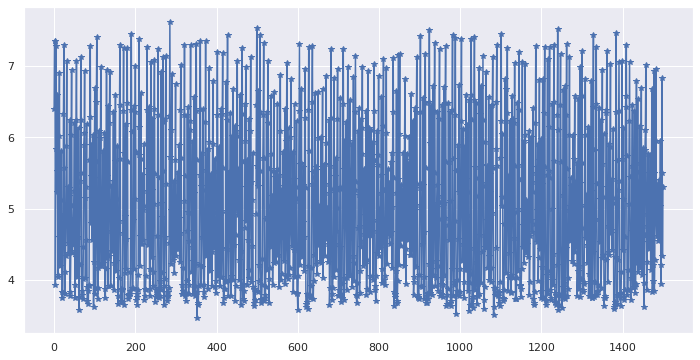

Train Accuraty:0.5550	Test Accuraty:0.5407
True Positives:970	False Positives:137
False Negatives:4283	True Negatives:4233
Accuracy:0.5407
Recall:0.1847	Precision:0.8762
f1 measure:0.3050


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE,epochs = EPOCHS, batch_size = BATCH_SIZE, label = 'NO_ONE.NO_PREP.LOG', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

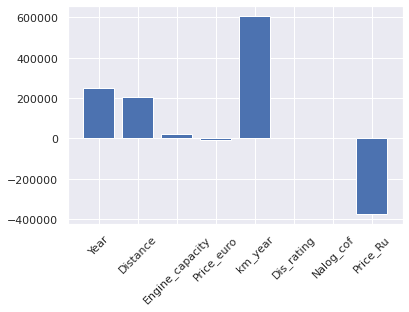

In [ ]:
#посмотрим веса: 
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


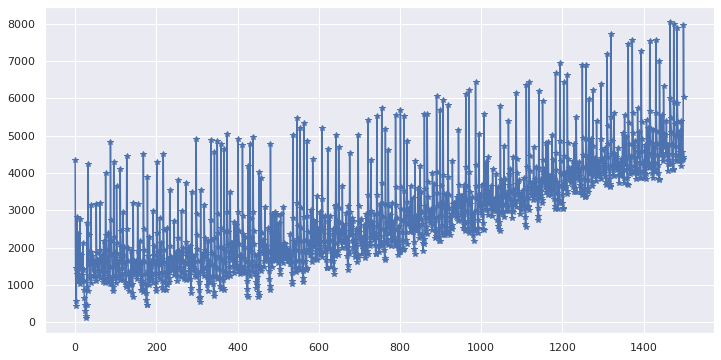

Train Accuraty:0.5996	Test Accuraty:0.5888
True Positives:1549	False Positives:253
False Negatives:3704	True Negatives:4117
Accuracy:0.5888
Recall:0.2949	Precision:0.8596
f1 measure:0.4391


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
#проведем тест с регуляризацией L2:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS, 
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY,
                          label = 'NO_ONE.NO_PREP.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

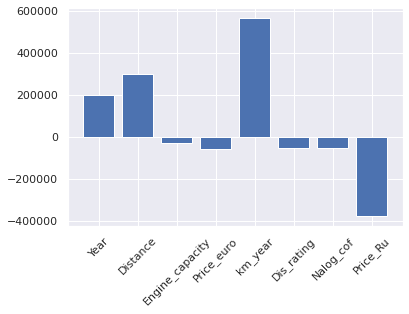

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Проведем тест с L1 регуляризацией

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


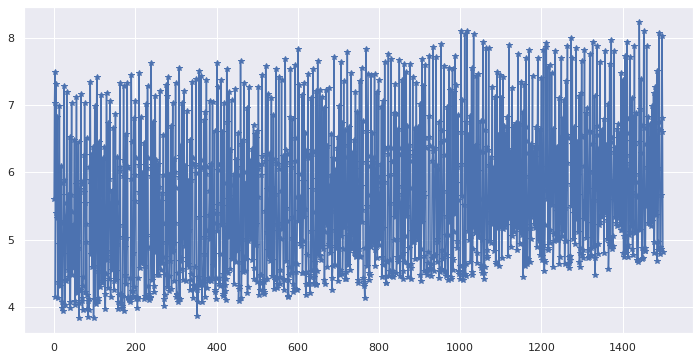

Train Accuraty:0.7232	Test Accuraty:0.7259
True Positives:3749	False Positives:1134
False Negatives:1504	True Negatives:3236
Accuracy:0.7259
Recall:0.7137	Precision:0.7678
f1 measure:0.7397


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          label = 'NO_ONE.NO_PREP.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

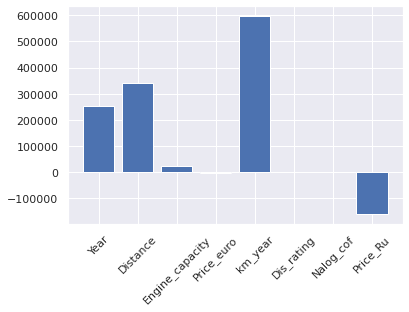

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Эластичная регуляризация

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


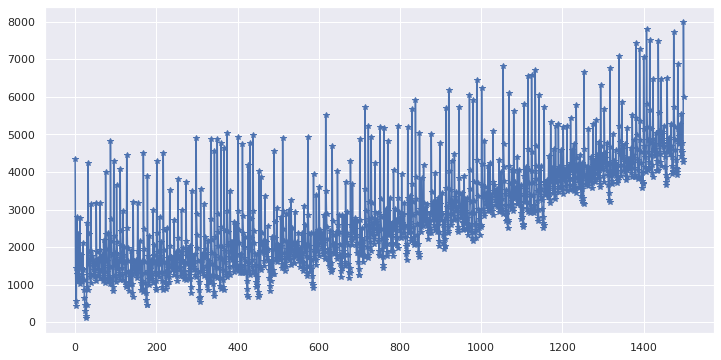

Train Accuraty:0.5934	Test Accuraty:0.5828
True Positives:1468	False Positives:230
False Negatives:3785	True Negatives:4140
Accuracy:0.5828
Recall:0.2795	Precision:0.8645
f1 measure:0.4224


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY,
                          label = 'NO_ONE.NO_PREP.ELAS', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

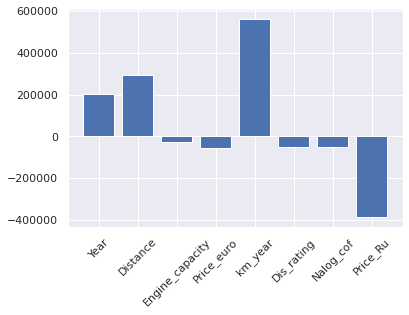

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

б) Стандартизация

In [ ]:
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7
22446,-0.741632,0.650045,0.048502,-0.492578,-0.316457,0.903686,-0.504121,-0.492578
22447,-0.044707,0.572938,1.036807,-0.162001,0.234820,0.903686,1.338605,-0.162001
22448,-0.323477,1.159206,-0.108579,-0.364678,0.406070,0.903686,-0.504121,-0.364678
22449,-0.323477,1.211826,0.218674,-0.487244,0.447102,0.903686,-0.504121,-0.487244
22450,-3.529335,1.200811,-2.726606,-0.897931,-1.030507,-0.299960,-0.504121,-0.897931


## Логистическая регрессия

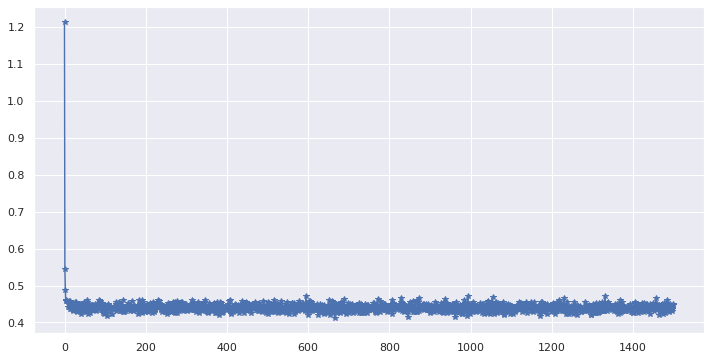

Train Accuraty:0.8080	Test Accuraty:0.8132
True Positives:4562	False Positives:1107
False Negatives:691	True Negatives:3263
Accuracy:0.8132
Recall:0.8685	Precision:0.8047
f1 measure:0.8354


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE,epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          label = 'NO_ONE.STANDART.LOG', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

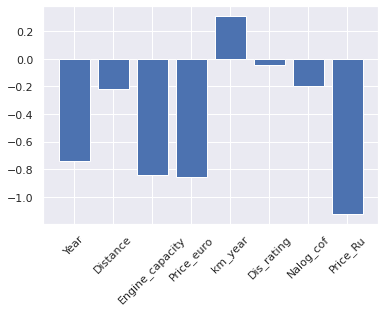

In [ ]:
# посмотрим веса
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Проведем тест с регуляризацией L2

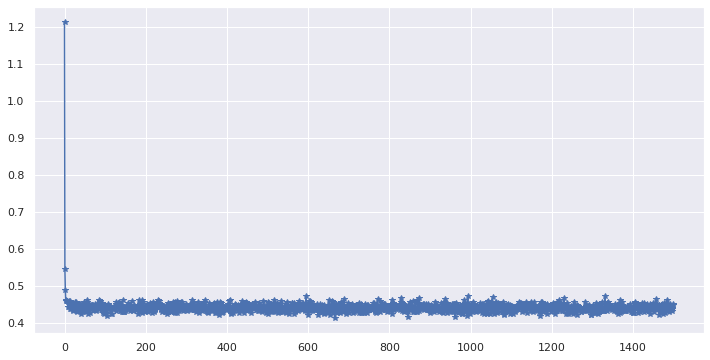

Train Accuraty:0.8083	Test Accuraty:0.8132
True Positives:4564	False Positives:1109
False Negatives:689	True Negatives:3261
Accuracy:0.8132
Recall:0.8688	Precision:0.8045
f1 measure:0.8354


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY,
                          label = 'NO_ONE.STANDART.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

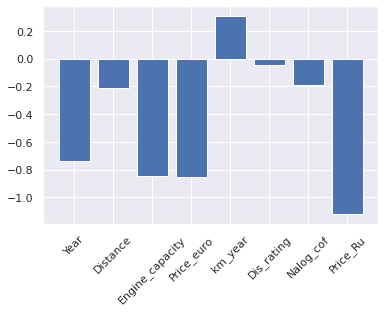

In [ ]:
# посмотрим веса
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Проведем тест с L1 регуляризацией

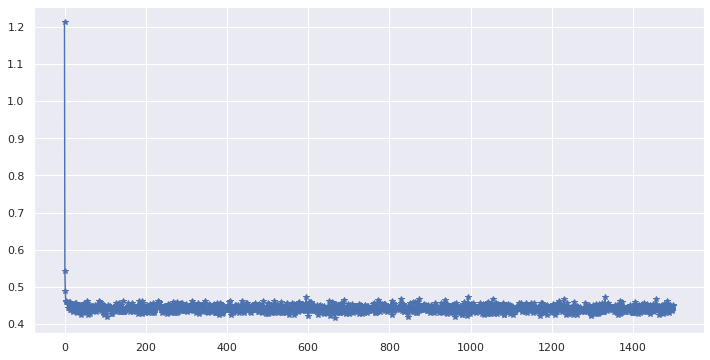

Train Accuraty:0.8072	Test Accuraty:0.8145
True Positives:4588	False Positives:1120
False Negatives:665	True Negatives:3250
Accuracy:0.8145
Recall:0.8734	Precision:0.8038
f1 measure:0.8371


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          label = 'NO_ONE.STANDART.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

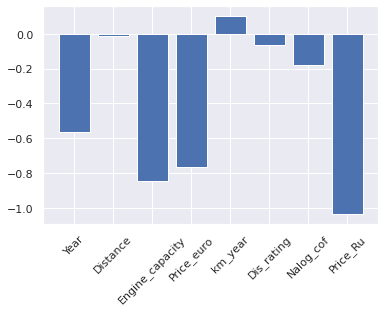

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Эластичная регуляризация

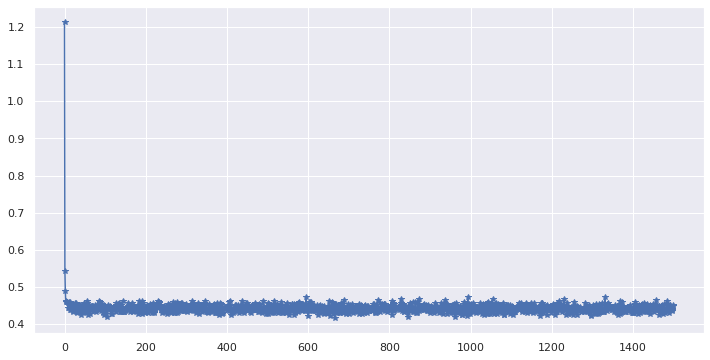

Train Accuraty:0.8072	Test Accuraty:0.8144
True Positives:4588	False Positives:1121
False Negatives:665	True Negatives:3249
Accuracy:0.8144
Recall:0.8734	Precision:0.8036
f1 measure:0.8371


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY,
                          label = 'NO_ONE.STANDART.ELAST', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

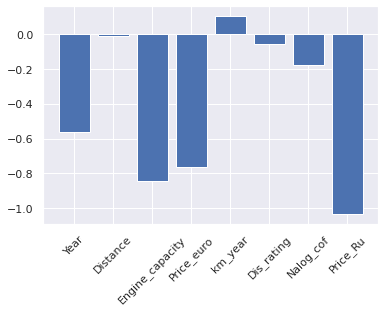

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

в) Нормализация

In [ ]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7
22446,0.64,0.479896,0.353333,0.046092,0.251134,1.0,0.000000,0.046092
22447,0.74,0.465893,0.479167,0.077144,0.331520,1.0,0.333333,0.077144
22448,0.70,0.572360,0.333333,0.058106,0.356492,1.0,0.000000,0.058106
22449,0.70,0.581916,0.375000,0.046593,0.362475,1.0,0.000000,0.046593
22450,0.24,0.579916,0.000000,0.008016,0.147012,0.5,0.000000,0.008016


## Логистическая регрессия

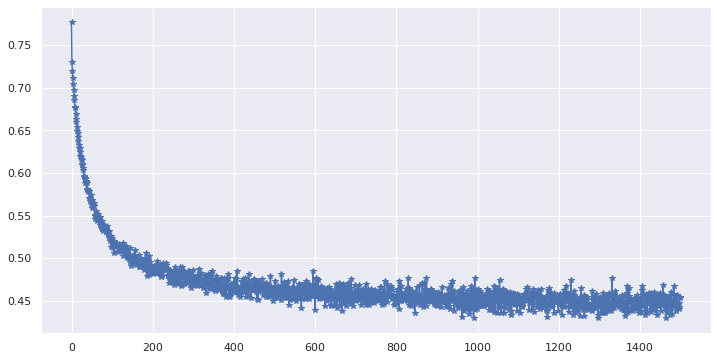

Train Accuraty:0.8038	Test Accuraty:0.8118
True Positives:4538	False Positives:1096
False Negatives:715	True Negatives:3274
Accuracy:0.8118
Recall:0.8639	Precision:0.8055
f1 measure:0.8337


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE,epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          label = 'NO_ONE.NORMA.LOG', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

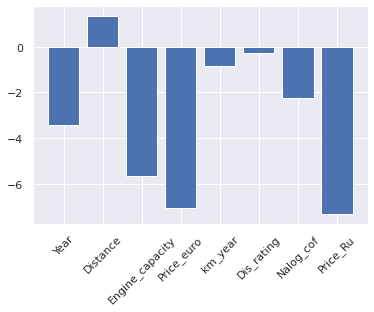

In [ ]:
# посмотрим веса
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Проведем тест с регуляризацией L2

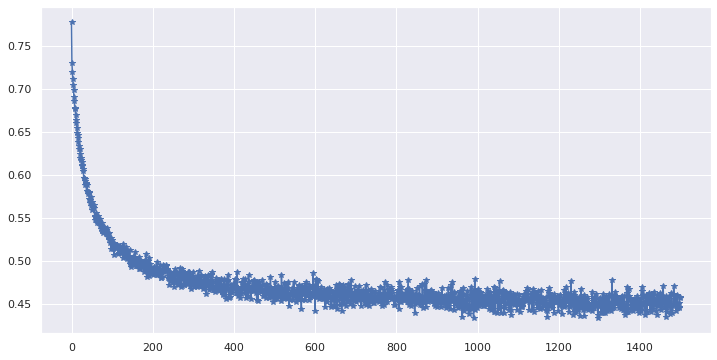

Train Accuraty:0.8025	Test Accuraty:0.8101
True Positives:4546	False Positives:1120
False Negatives:707	True Negatives:3250
Accuracy:0.8101
Recall:0.8654	Precision:0.8023
f1 measure:0.8327


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY,
                          label = 'NO_ONE.NORMA.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

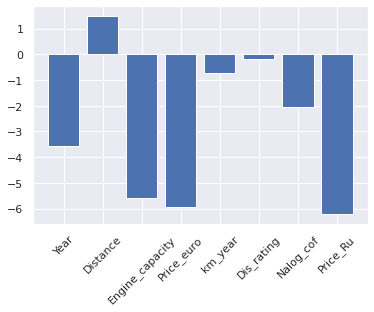

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Проведем тест с L1 регуляризацией

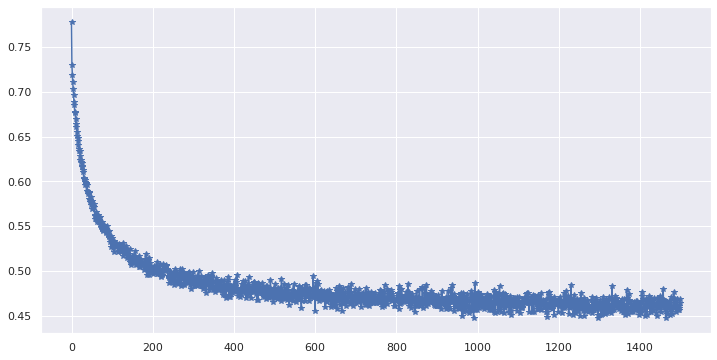

Train Accuraty:0.8017	Test Accuraty:0.8090
True Positives:4581	False Positives:1166
False Negatives:672	True Negatives:3204
Accuracy:0.8090
Recall:0.8721	Precision:0.7971
f1 measure:0.8329


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          label = 'NO_ONE.NORMA.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

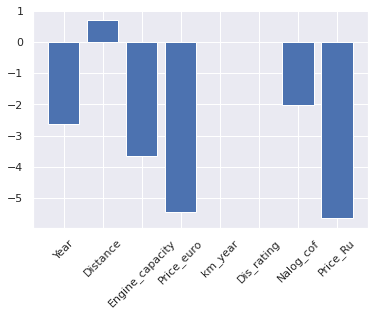

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Эластичная регуляризация

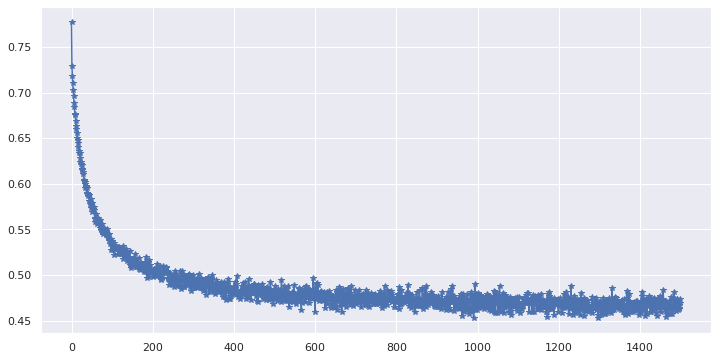

Train Accuraty:0.8004	Test Accuraty:0.8086
True Positives:4590	False Positives:1179
False Negatives:663	True Negatives:3191
Accuracy:0.8086
Recall:0.8738	Precision:0.7956
f1 measure:0.8329


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY, label = 'NO_ONE.NORMA.ELAST',
                          df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

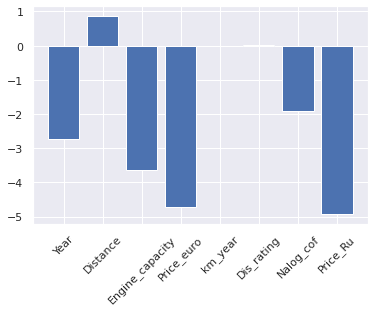

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

г) Cтепенное преобразование

In [ ]:
scaler  = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7
22446,-0.884819,0.678348,0.142521,-0.507107,-0.250415,0.937654,-0.553794,-0.507107
22447,-0.218047,0.605407,1.074183,0.141318,0.311408,0.937654,1.795739,0.141318
22448,-0.503989,1.148098,-0.021658,-0.233412,0.476349,0.937654,-0.553794,-0.233412
22449,-0.503989,1.195516,0.315022,-0.495054,0.515239,0.937654,-0.553794,-0.495054
22450,-2.333674,1.185607,-3.718187,-1.618186,-1.058145,-0.450447,-0.553794,-1.618186


## Логистическая регрессия

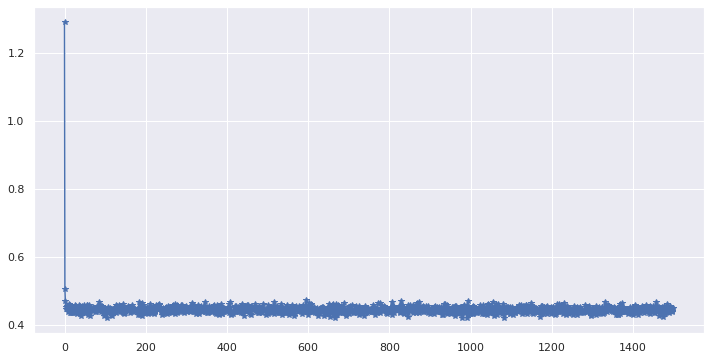

Train Accuraty:0.8019	Test Accuraty:0.8087
True Positives:4465	False Positives:1053
False Negatives:788	True Negatives:3317
Accuracy:0.8087
Recall:0.8500	Precision:0.8092
f1 measure:0.8291


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE,epochs = EPOCHS,
                          batch_size = BATCH_SIZE, label = 'NO_ONE.POWER.LOG',
                          df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

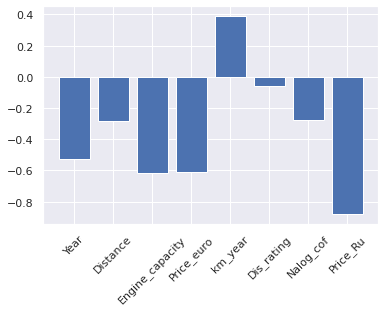

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Проведем тест с регуляризацией L2

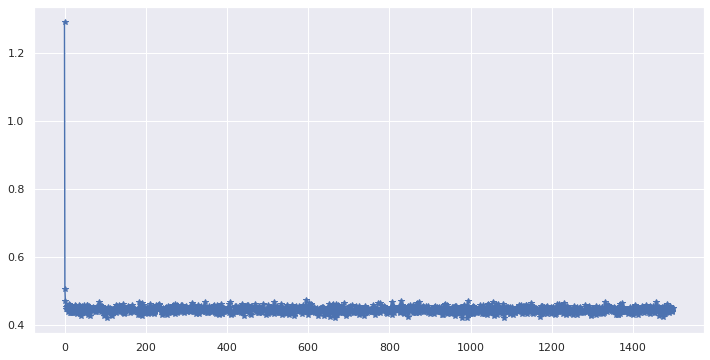

Train Accuraty:0.8018	Test Accuraty:0.8085
True Positives:4466	False Positives:1056
False Negatives:787	True Negatives:3314
Accuracy:0.8085
Recall:0.8502	Precision:0.8088
f1 measure:0.8290


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY,
                          label = 'NO_ONE.POWER.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

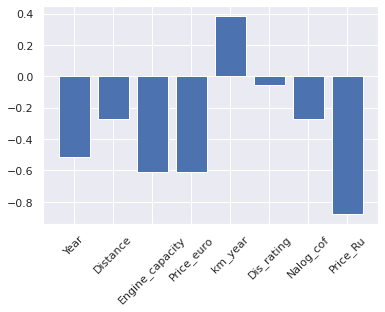

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Проведем тест с L1 регуляризацией

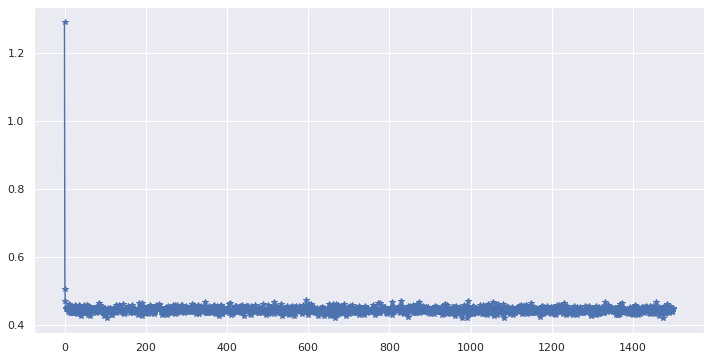

Train Accuraty:0.8010	Test Accuraty:0.8080
True Positives:4452	False Positives:1047
False Negatives:801	True Negatives:3323
Accuracy:0.8080
Recall:0.8475	Precision:0.8096
f1 measure:0.8281


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS, 
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          label = 'NO_ONE.POWER.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

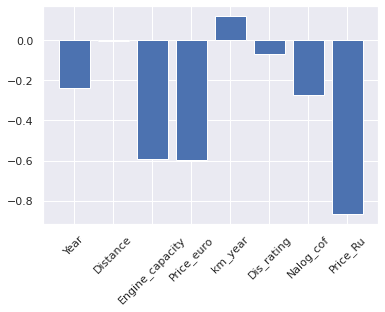

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## Эластичная регуляризация

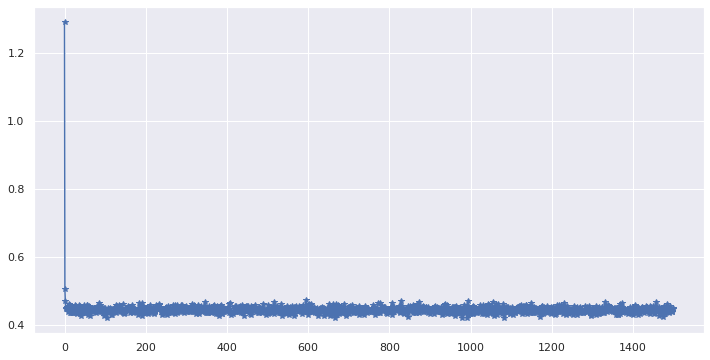

Train Accuraty:0.8010	Test Accuraty:0.8079
True Positives:4453	False Positives:1049
False Negatives:800	True Negatives:3321
Accuracy:0.8079
Recall:0.8477	Precision:0.8093
f1 measure:0.8281


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS, 
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY,
                          label = 'NO_ONE.POWER.ELAST', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

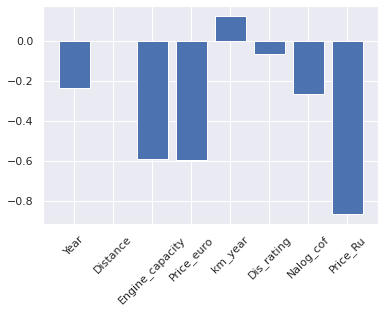

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

## **2) C One-Hote Кодирования**

In [ ]:
# подключим файлы:
DF = pd.read_csv('/content/drive/MyDrive/lectures/mf-ml/colab/dz/3/date/cars_moldova_clean-v2.csv', delimiter = ',')

In [ ]:
#произведём и склеим One-hote кодирование без столбца Трансмиссия, затем его приобразовываем в бинарный тип:
DF_one = pd.get_dummies(DF.drop(columns = ['Transmission']))
DF_one['Transmission'] = DF['Transmission']

DF_one['Transmission'] = DF_one['Transmission'].astype('category').cat.codes

In [ ]:
num_columns = DF_one.drop(columns = ['Transmission']).columns

In [ ]:
X = DF_one[num_columns].values 
y = DF_one["Transmission"].values 
features_names = DF_one[num_columns].columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

а) Без предварительно обработки
Рассмотрим работоспособность модели

## Логистическая регрессия

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


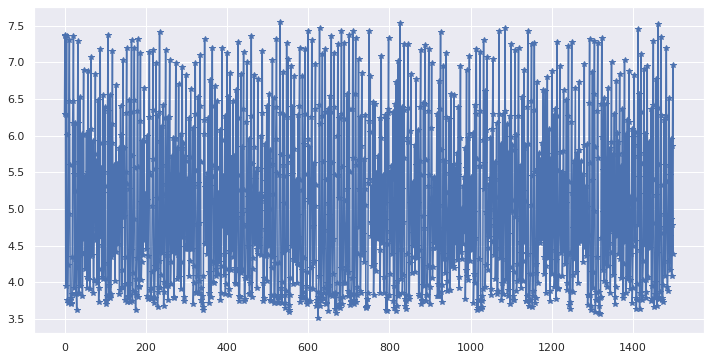

Train Accuraty:0.6914	Test Accuraty:0.7059
True Positives:4750	False Positives:2327
False Negatives:503	True Negatives:2043
Accuracy:0.7059
Recall:0.9042	Precision:0.6712
f1 measure:0.7705


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE,epochs = EPOCHS, 
                          batch_size = BATCH_SIZE,
                          label = 'ONE-HOTE.NO_PREP.LOG', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

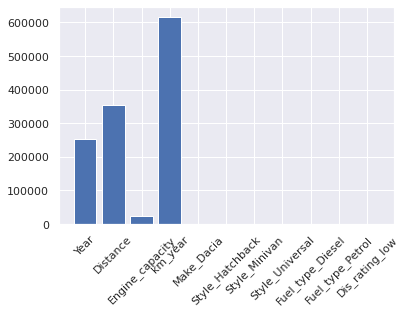

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с регуляризацией L2

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


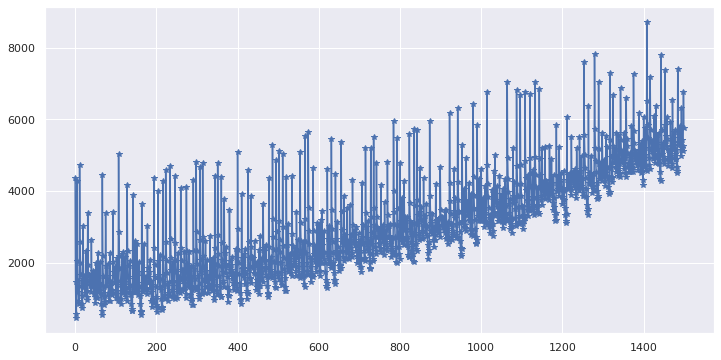

Train Accuraty:0.6810	Test Accuraty:0.6822
True Positives:2850	False Positives:655
False Negatives:2403	True Negatives:3715
Accuracy:0.6822
Recall:0.5425	Precision:0.8131
f1 measure:0.6508


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY,
                          label = 'ONE-HOTE.NO_PREP.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

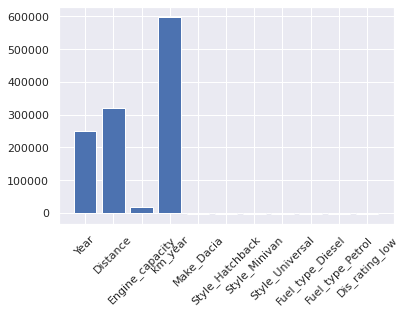

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с L1 регуляризацией

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


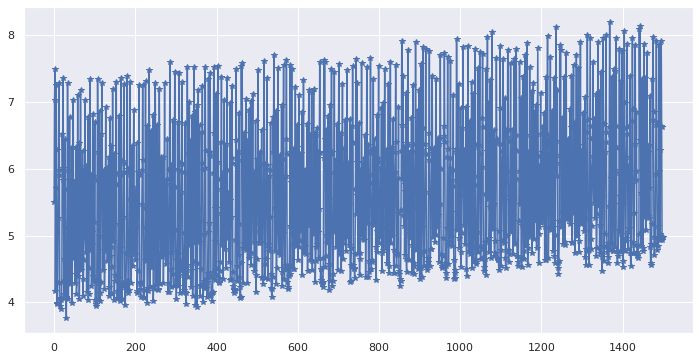

Train Accuraty:0.6757	Test Accuraty:0.6752
True Positives:2737	False Positives:610
False Negatives:2516	True Negatives:3760
Accuracy:0.6752
Recall:0.5210	Precision:0.8177
f1 measure:0.6365


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS, 
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          label = 'ONE-HOTE.NO_PREP.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

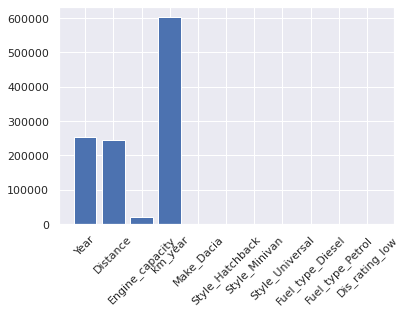

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Эластичная регуляризация

<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


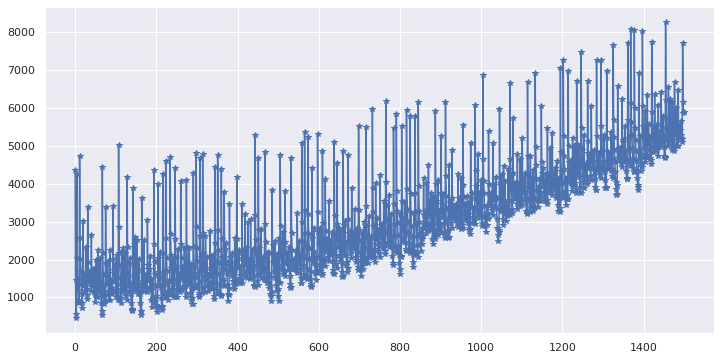

Train Accuraty:0.6378	Test Accuraty:0.6309
True Positives:2109	False Positives:408
False Negatives:3144	True Negatives:3962
Accuracy:0.6309
Recall:0.4015	Precision:0.8379
f1 measure:0.5429


<ipython-input-4-132117507859>:41: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY,
                          label = 'ONE-HOTE.NO_PREP.ELAST', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

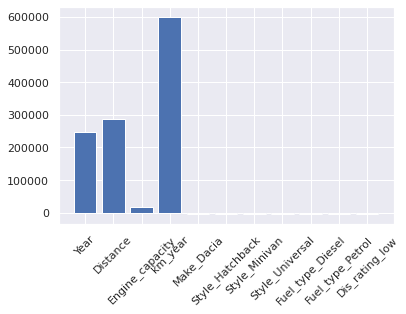

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

б) Стандартизация

In [ ]:
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
22446,-0.741632,0.650045,0.048502,-0.492578,-0.316457,-0.504121,-0.492578,-0.0347,-0.224254,-0.296569,...,-0.470557,1.059066,-0.02986,-0.249734,-0.347984,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22447,-0.044707,0.572938,1.036807,-0.162001,0.234820,1.338605,-0.162001,-0.0347,-0.224254,-0.296569,...,-0.470557,1.059066,-0.02986,-0.249734,-0.347984,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22448,-0.323477,1.159206,-0.108579,-0.364678,0.406070,-0.504121,-0.364678,-0.0347,-0.224254,-0.296569,...,-0.470557,-0.944228,-0.02986,-0.249734,2.873699,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22449,-0.323477,1.211826,0.218674,-0.487244,0.447102,-0.504121,-0.487244,-0.0347,-0.224254,-0.296569,...,-0.470557,-0.944228,-0.02986,-0.249734,2.873699,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22450,-3.529335,1.200811,-2.726606,-0.897931,-1.030507,-0.504121,-0.897931,-0.0347,-0.224254,-0.296569,...,-0.470557,-0.944228,-0.02986,-0.249734,-0.347984,1.371196,-0.11852,-0.579768,1.742971,-1.001560


## Логистическая регрессия

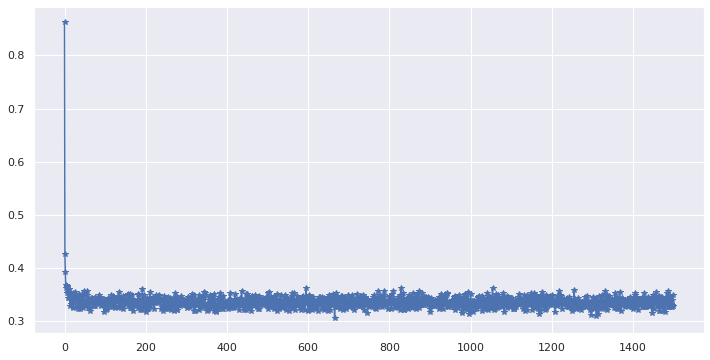

Train Accuraty:0.8563	Test Accuraty:0.8560
True Positives:4713	False Positives:846
False Negatives:540	True Negatives:3524
Accuracy:0.8560
Recall:0.8972	Precision:0.8478
f1 measure:0.8718


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE,epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          label = 'ONE-HOTE.STANDART.LOG', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

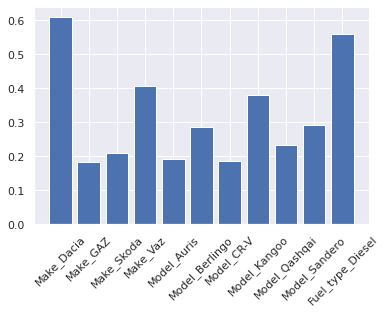

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с регуляризацией L2

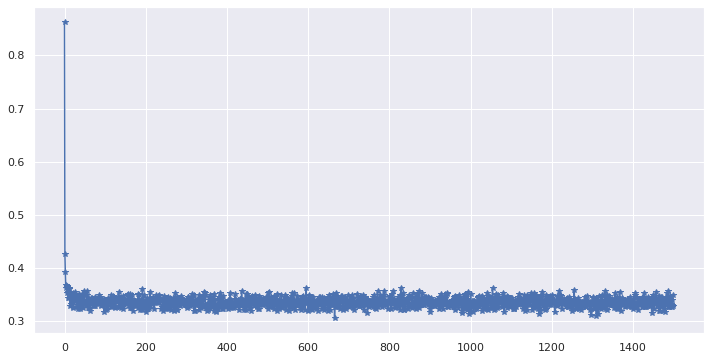

Train Accuraty:0.8563	Test Accuraty:0.8560
True Positives:4713	False Positives:846
False Negatives:540	True Negatives:3524
Accuracy:0.8560
Recall:0.8972	Precision:0.8478
f1 measure:0.8718


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS, 
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY, 
                          label = 'ONE-HOTE.STANDART.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

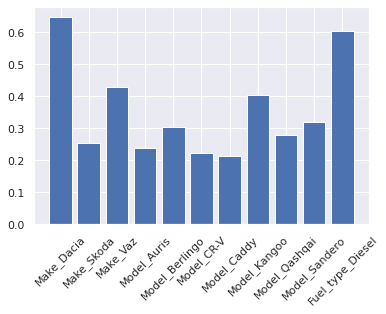

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с L1 регуляризацией

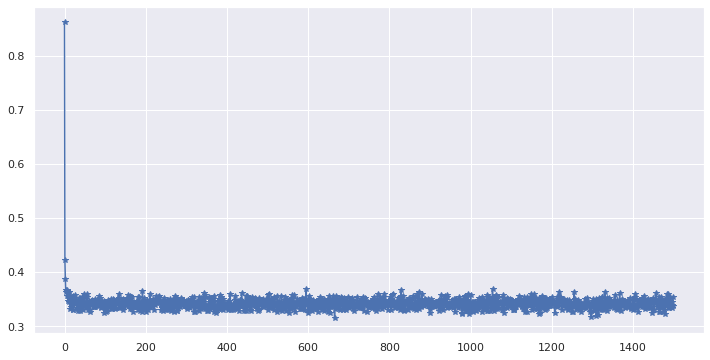

Train Accuraty:0.8548	Test Accuraty:0.8541
True Positives:4733	False Positives:884
False Negatives:520	True Negatives:3486
Accuracy:0.8541
Recall:0.9010	Precision:0.8426
f1 measure:0.8708


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          label = 'ONE-HOTE.STANDART.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

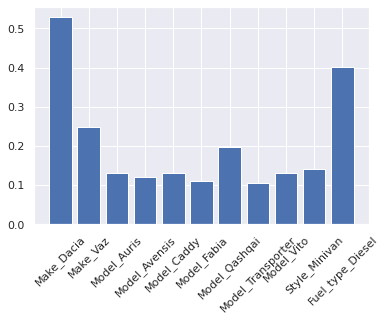

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Эластичная регуляризация

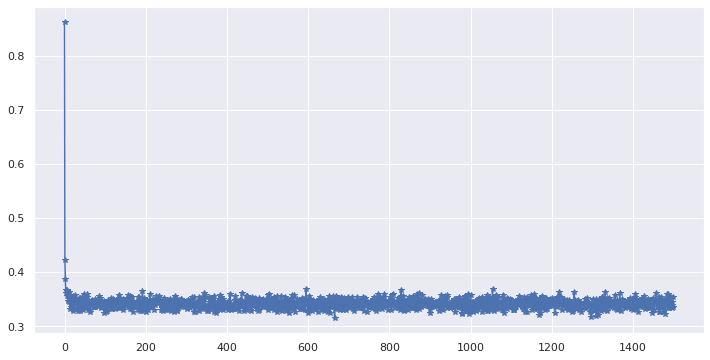

Train Accuraty:0.8548	Test Accuraty:0.8539
True Positives:4731	False Positives:884
False Negatives:522	True Negatives:3486
Accuracy:0.8539
Recall:0.9006	Precision:0.8426
f1 measure:0.8706


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY,
                          label = 'ONE-HOTE.STANDART.ELAST', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

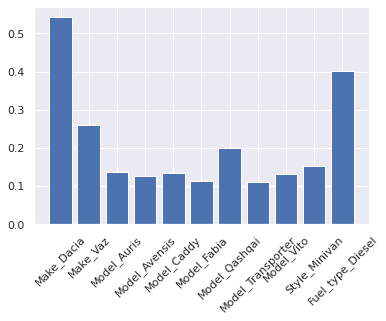

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

г) Нормализация

In [ ]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
22446,0.64,0.479896,0.353333,0.046092,0.251134,0.000000,0.046092,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22447,0.74,0.465893,0.479167,0.077144,0.331520,0.333333,0.077144,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22448,0.70,0.572360,0.333333,0.058106,0.356492,0.000000,0.058106,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22449,0.70,0.581916,0.375000,0.046593,0.362475,0.000000,0.046593,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22450,0.24,0.579916,0.000000,0.008016,0.147012,0.000000,0.008016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Логистическая регрессия

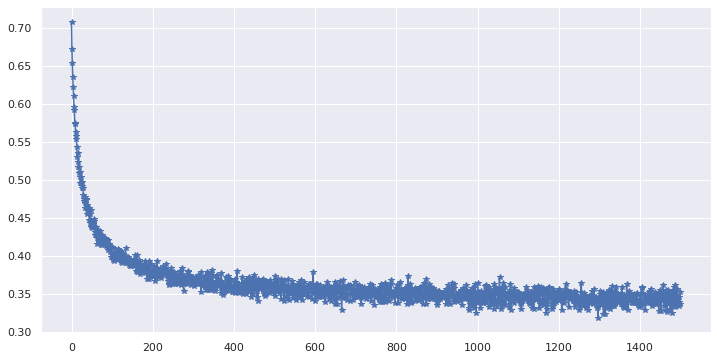

Train Accuraty:0.8532	Test Accuraty:0.8522
True Positives:4685	False Positives:854
False Negatives:568	True Negatives:3516
Accuracy:0.8522
Recall:0.8919	Precision:0.8458
f1 measure:0.8682


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE,
                          epochs = EPOCHS, batch_size = BATCH_SIZE,
                          label = 'ONE-HOTE.NORMA.LOG', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

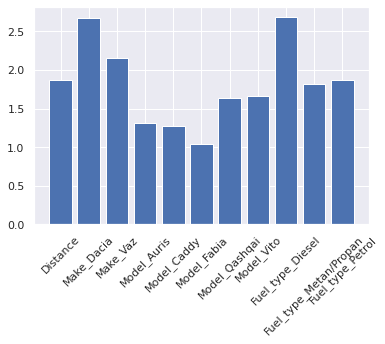

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с регуляризацией L2

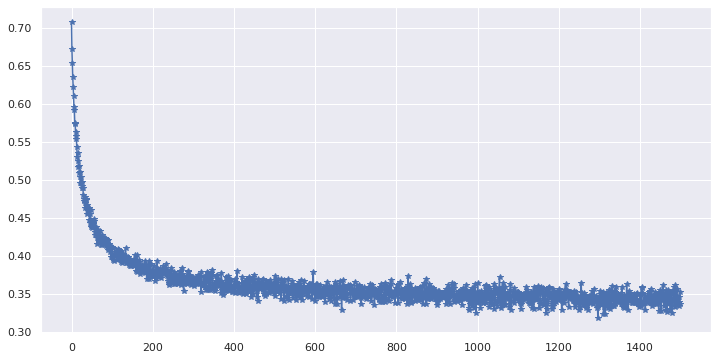

Train Accuraty:0.8531	Test Accuraty:0.8523
True Positives:4685	False Positives:853
False Negatives:568	True Negatives:3517
Accuracy:0.8523
Recall:0.8919	Precision:0.8460
f1 measure:0.8683


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS, 
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY,
                          label = 'ONE-HOTE.NORMA.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

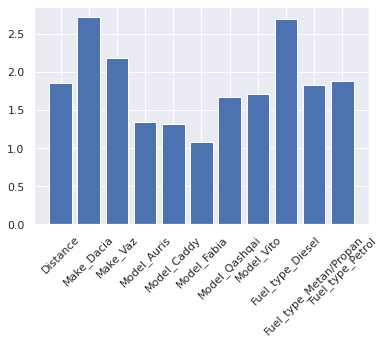

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с L1 регуляризацией

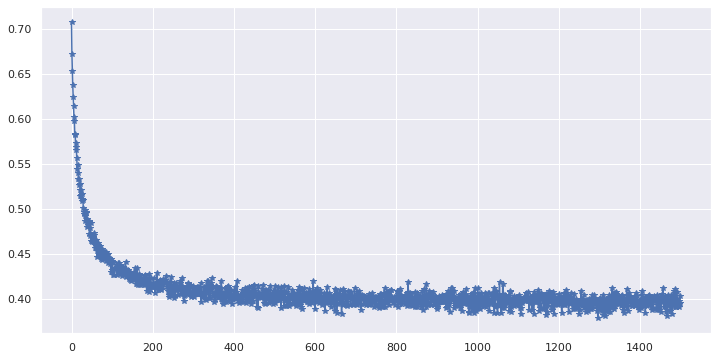

Train Accuraty:0.8370	Test Accuraty:0.8412
True Positives:4673	False Positives:948
False Negatives:580	True Negatives:3422
Accuracy:0.8412
Recall:0.8896	Precision:0.8313
f1 measure:0.8595


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY, 
                          label = 'ONE-HOTE.NORMA.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

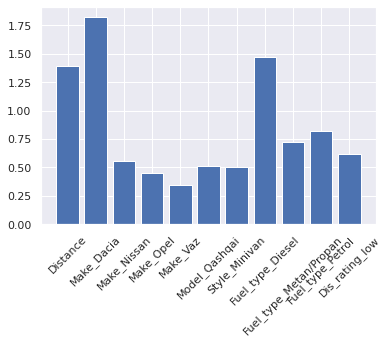

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Эластичная регуляризация

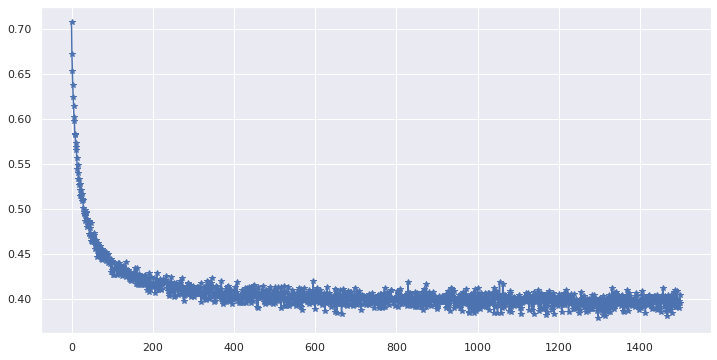

Train Accuraty:0.8363	Test Accuraty:0.8405
True Positives:4669	False Positives:951
False Negatives:584	True Negatives:3419
Accuracy:0.8405
Recall:0.8888	Precision:0.8308
f1 measure:0.8588


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY,
                          label = 'ONE-HOTE.NORMA.ELAST', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

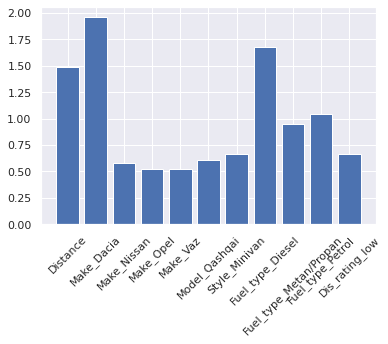

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

д) Cтепенное преобразование

In [ ]:
scaler  = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
22446,-0.884819,0.678348,0.142521,-0.507107,-0.250415,-0.553794,-0.507107,-0.0347,-0.224254,-0.296569,...,-0.470557,1.059066,-0.02986,-0.249734,-0.347984,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22447,-0.218047,0.605407,1.074183,0.141318,0.311408,1.795739,0.141318,-0.0347,-0.224254,-0.296569,...,-0.470557,1.059066,-0.02986,-0.249734,-0.347984,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22448,-0.503989,1.148098,-0.021658,-0.233412,0.476349,-0.553794,-0.233412,-0.0347,-0.224254,-0.296569,...,-0.470557,-0.944228,-0.02986,-0.249734,2.873699,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22449,-0.503989,1.195516,0.315022,-0.495054,0.515239,-0.553794,-0.495054,-0.0347,-0.224254,-0.296569,...,-0.470557,-0.944228,-0.02986,-0.249734,2.873699,-0.729290,-0.11852,-0.579768,-0.573733,0.998442
22450,-2.333674,1.185607,-3.718187,-1.618186,-1.058145,-0.553794,-1.618186,-0.0347,-0.224254,-0.296569,...,-0.470557,-0.944228,-0.02986,-0.249734,-0.347984,1.371196,-0.11852,-0.579768,1.742971,-1.001560


## Логистическая регрессия

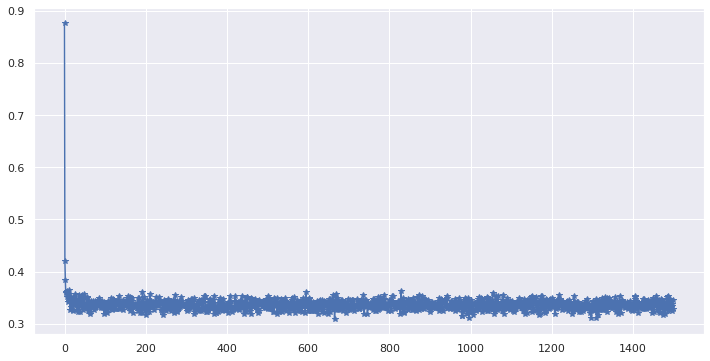

Train Accuraty:0.8535	Test Accuraty:0.8531
True Positives:4672	False Positives:833
False Negatives:581	True Negatives:3537
Accuracy:0.8531
Recall:0.8894	Precision:0.8487
f1 measure:0.8686


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE,
                          label = 'ONE-HOTE.POWER.LOG', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

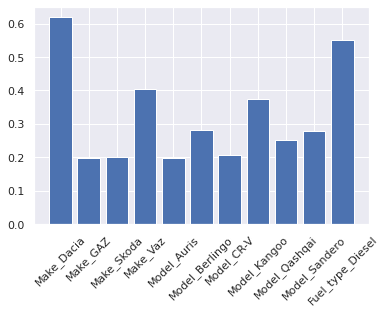

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с регуляризацией L2

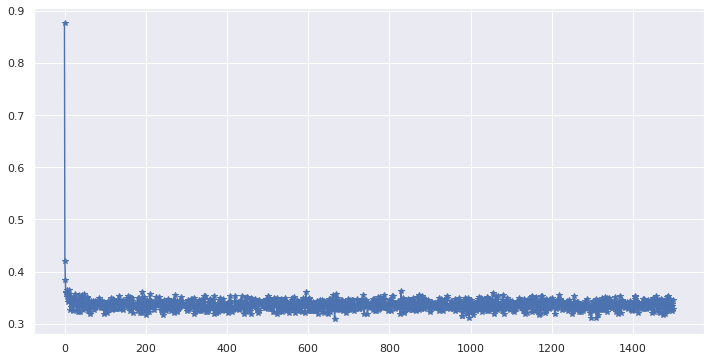

Train Accuraty:0.8535	Test Accuraty:0.8531
True Positives:4672	False Positives:833
False Negatives:581	True Negatives:3537
Accuracy:0.8531
Recall:0.8894	Precision:0.8487
f1 measure:0.8686


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS, 
                          batch_size = BATCH_SIZE, l2_penalty = L2_PENALTY,
                          label = 'ONE-HOTE.POWER.L2', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

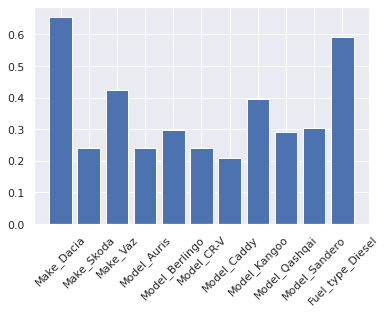

In [ ]:
# посмотрим веса:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## Проведем тест с L1 регуляризацией

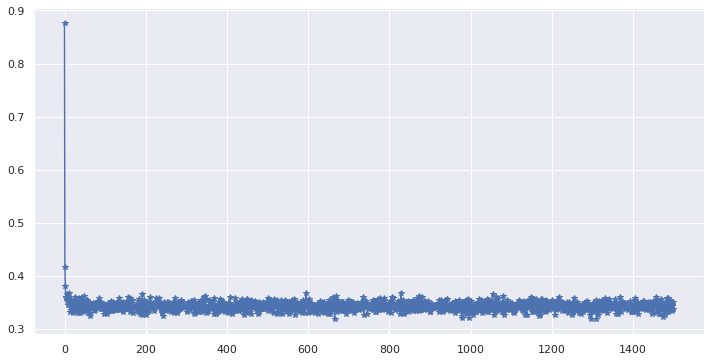

Train Accuraty:0.8513	Test Accuraty:0.8494
True Positives:4651	False Positives:847
False Negatives:602	True Negatives:3523
Accuracy:0.8494
Recall:0.8854	Precision:0.8459
f1 measure:0.8652


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          label = 'ONE-HOTE.POWER.L1', df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

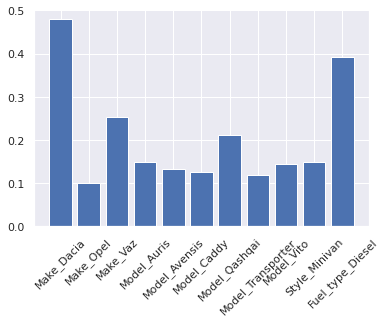

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

In [ ]:
w

array([-5.44202511e-01,  6.04550786e-03, -3.52042370e-01, -5.84165816e-01,
       -6.41767478e-03, -3.33552467e-01, -5.80260862e-01,  3.31565423e-02,
       -1.31403571e-01, -1.10824072e-01, -1.43694288e-02, -7.27194795e-02,
       -5.89311892e-03,  4.87593680e-01,  1.26648541e-02, -3.94385882e-02,
       -4.05723777e-02,  2.20029984e-02,  4.12956847e-02,  4.56523739e-02,
        1.91044399e-03,  6.31207105e-03, -6.45836347e-02, -1.35145076e-02,
       -3.28421264e-02, -2.07816037e-02, -9.83396554e-02, -1.06848404e-01,
       -4.66160293e-02, -9.85101588e-03, -2.03783690e-01, -2.23256253e-03,
        5.65636135e-03,  6.06926035e-03,  9.17765021e-02,  1.04462699e-01,
        1.16078973e-02, -1.18567305e-05,  1.10504371e-02,  1.09859481e-02,
        3.23038864e-04,  3.37602605e-03,  3.69005562e-02,  1.00747356e-01,
       -1.09679298e-01, -1.62855989e-02, -4.99747068e-04,  1.19385165e-02,
        8.45245472e-04,  2.59797459e-01,  8.93209035e-03, -3.61636946e-02,
        5.20611836e-02,  

In [ ]:
b

0.0047625536894423184

## Эластичная регуляризация

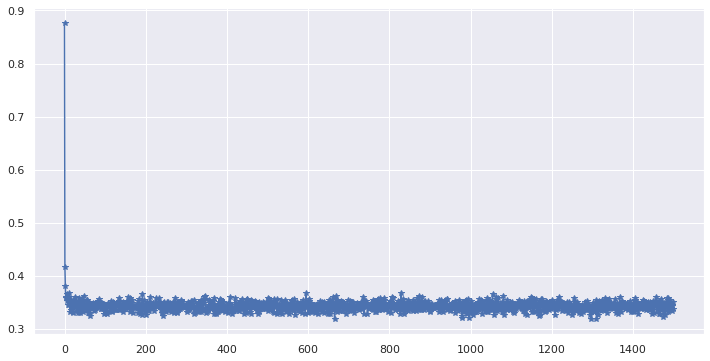

Train Accuraty:0.8511	Test Accuraty:0.8490
True Positives:4650	False Positives:850
False Negatives:603	True Negatives:3520
Accuracy:0.8490
Recall:0.8852	Precision:0.8455
f1 measure:0.8649


In [ ]:
regr = LogisticRegression(learning_rate = LEARNING_RATE, epochs = EPOCHS,
                          batch_size = BATCH_SIZE, l1_penalty = L1_PENALTY,
                          l2_penalty = L2_PENALTY, label = 'ONE-HOTE.POWER.ELAST',
                          df_report = DF_REPORT)

regr.fit(X_train, y_train)

regr.plot_cost()

regr.classification_report(X_test, y_test, X_train, y_train)

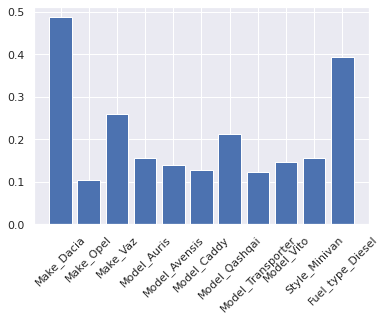

In [ ]:
w, b = regr.get_w_and_b()
DF_w = pd.DataFrame()
DF_w['w'], DF_w['features_names']  = w, features_names
DF_wMax = DF_w[DF_w['w'] > DF_w.w.quantile(QUANTILE_W)]

plt.bar(x = range(DF_wMax.shape[0]),height=DF_wMax.w)
plt.xticks(range(DF_wMax.shape[0]),DF_wMax['features_names'], rotation = 45 );

## ВЫВОД:

Наиболее значиемые признаки без One-hote:
1. Без предварительной обработки:
* а) Год выпуска
* б) Общий пробег
* в) Пробег в год
* г) Цена

2. После предварительной обработки:
* а) Год выпуска
* б) Цена - Руб
* в) Цена - Евро
* г) Объем двигателя

Наиболее значиемые признаки при One-hote:
1. Без предварительной обработки:
* а) Год выпуска
* б) Общий пробег
* в) Пробег в год

2. После предварительной обработки:
* а) Тип топлива - Дизель
* б) Производитель - Dacia
* в) Производитель - VAZ



In [ ]:
DF_total = regr.get_df_report()

In [ ]:
DF_total

,label,Train Accuracy,Test Accuracy,True Positives,False Positives,False Negatives,True Negatives,Accuracy,Recall,Precision,F1 measureall
0,NO_ONE.NO_PREP.LOG,0.555031,0.540684,970.0,137.0,4283.0,4233.0,0.540684,0.184656,0.876242,0.305031
1,NO_ONE.NO_PREP.L2,0.599617,0.588798,1549.0,253.0,3704.0,4117.0,0.588798,0.294879,0.859600,0.439121
2,NO_ONE.NO_PREP.L1,0.723175,0.725865,3749.0,1134.0,1504.0,3236.0,0.725865,0.713687,0.767766,0.739740
3,NO_ONE.NO_PREP.ELAS,0.593426,0.582770,1468.0,230.0,3785.0,4140.0,0.582770,0.279459,0.864547,0.422385
4,NO_ONE.STANDART.LOG,0.808026,0.813156,4562.0,1107.0,691.0,3263.0,0.813156,0.868456,0.804727,0.835378
5,NO_ONE.STANDART.L2,0.808294,0.813156,4564.0,1109.0,689.0,3261.0,0.813156,0.868837,0.804513,0.835438
6,NO_ONE.STANDART.L1,0.807225,0.814507,4588.0,1120.0,665.0,3250.0,0.814507,0.873406,0.803784,0.837150
7,NO_ONE.STANDART.ELAST,0.807225,0.814403,4588.0,1121.0,665.0,3249.0,0.814403,0.873406,0.803643,0.837074
8,NO_ONE.NORMA.LOG,0.803839,0.811805,4538.0,1096.0,715.0,3274.0,0.811805,0.863887,0.805467,0.833655
9,NO_ONE.NORMA.L2,0.802548,0.810142,4546.0,1120.0,707.0,3250.0,0.810142,0.865410,0.802330,0.832677


In [ ]:
DF_total[DF_total['F1 measureall'] > DF_total['F1 measureall'].quantile(.90)]

,label,Train Accuracy,Test Accuracy,True Positives,False Positives,False Negatives,True Negatives,Accuracy,Recall,Precision,F1 measureall
20,ONE-HOTE.STANDART.LOG,0.856265,0.855970,4713.0,846.0,540.0,3524.0,0.855970,0.897202,0.847814,0.871809
21,ONE-HOTE.STANDART.L2,0.856265,0.855970,4713.0,846.0,540.0,3524.0,0.855970,0.897202,0.847814,0.871809
22,ONE-HOTE.STANDART.L1,0.854795,0.854100,4733.0,884.0,520.0,3486.0,0.854100,0.901009,0.842621,0.870837
23,ONE-HOTE.STANDART.ELAST,0.854750,0.853892,4731.0,884.0,522.0,3486.0,0.853892,0.900628,0.842565,0.870629


Для этого набора данных лучше всего себя выражают модели с предварительной обработкой One-hote codding:

- стандартизированные 
- прошедшие логистическую регрессию
- л1
- л2 
- эластичные регуляризации

In [ ]:
DF_total[DF_total['F1 measureall'] == DF_total['F1 measureall'].max()]

,label,Train Accuracy,Test Accuracy,True Positives,False Positives,False Negatives,True Negatives,Accuracy,Recall,Precision,F1 measureall
20,ONE-HOTE.STANDART.LOG,0.856265,0.85597,4713.0,846.0,540.0,3524.0,0.85597,0.897202,0.847814,0.871809
21,ONE-HOTE.STANDART.L2,0.856265,0.85597,4713.0,846.0,540.0,3524.0,0.85597,0.897202,0.847814,0.871809


Самый лучший результат показали модели ONE-Hote:
- standart slacer 
- logistic regression 
- standart slacer 
- l2 regul